In [488]:
# importing modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from math import sqrt
from random import randint
import random
import time

In [489]:
# load file  
df = pd.read_csv('Outage_time_series.csv', parse_dates = ['outage_time_series.forecast_time_cdt'])

In [490]:
df = df.sort_values(by=['outage_time_series.forecast_time_cdt']) 
df.head(20)

,outage_time_series.forecast_time_cdt,outage_time_series.vgrd_925_mb,outage_time_series.ltng_entire_atmosphere,outage_time_series.wind_10_m_above_ground,outage_time_series.ugrd_1000_mb,outage_time_series.vgrd_250_mb,outage_time_series.asnow_surface,outage_time_series.cin_90_0_mb_above_ground,outage_time_series.tmp_700_mb,outage_time_series.cin_surface,...,outage_time_series.prate_surface,outage_time_series.pres_cloud_top,outage_time_series.mcdc_middle_cloud_layer,outage_time_series.ugrd_925_mb,outage_time_series.tmp_850_mb,outage_time_series.dswrf_surface,outage_time_series.vgrd_1000_mb,outage_time_series.mout_hrstrt,outage_time_series.dur_rolling,outage_time_series.meters_out
13154,2017-08-01 00:00:00,4424.746000,0.0,4616.63,-1401.064040,-3693.26441,0.0,-25160.0,172248.539,-31740.0,...,0.0,0.0,0.000,-3803.240540,176623.474,0.0,1092.715964,12,203.033333,12
1085,2017-08-01 01:00:00,3977.156130,0.0,3998.14,-1076.822920,-4327.75922,0.0,-150.0,172140.714,-54770.0,...,0.0,0.0,0.000,-4286.329210,176321.956,0.0,1139.402145,7,494.983333,15
2079,2017-08-01 02:00:00,4412.870240,0.0,3923.52,-852.059766,-4392.39239,0.0,0.0,172122.177,-56920.0,...,0.0,0.0,0.000,-3773.148090,175907.811,0.0,1204.813960,0,371.966667,7
14320,2017-08-01 03:00:00,4388.691680,0.0,3416.41,-523.599330,-4816.81117,0.0,0.0,172004.229,-36310.0,...,0.0,0.0,0.000,-3457.309150,175599.082,0.0,1079.949393,2,99.616667,6
11680,2017-08-01 04:00:00,4009.601400,0.0,2420.19,-495.900330,-5356.12060,0.0,-6320.0,171844.289,-22000.0,...,0.0,0.0,0.000,-2958.073240,175441.961,0.0,715.439696,2,78.566667,2
4199,2017-08-01 05:00:00,3429.099750,0.0,1508.24,-481.095632,-4661.19833,0.0,-6490.0,171524.942,-12920.0,...,0.0,99500.0,0.000,-2313.078400,175238.046,0.0,144.642150,1,64.800000,2
9129,2017-08-01 06:00:00,2044.587380,0.0,1389.53,-291.714895,-4988.36343,0.0,0.0,171507.678,-13640.0,...,0.0,99500.0,0.000,-3313.493150,175249.369,0.0,-422.033174,3,112.166667,4
1476,2017-08-01 07:00:00,2022.120540,0.0,1565.70,18.747601,-4151.39137,0.0,0.0,171412.296,-8670.0,...,0.0,1293800.0,0.000,-2060.676950,175172.461,0.0,-572.667298,49,1319.600000,49
12740,2017-08-01 08:00:00,1239.155700,0.0,1662.94,375.278325,-3667.68393,0.0,0.0,171364.672,-17470.0,...,0.0,1590400.0,0.000,-1137.641350,175224.251,93905.4,-511.723722,22,3153.050000,71
3373,2017-08-01 09:00:00,852.603559,0.0,1269.27,126.712760,-4118.54828,0.0,-446.0,171172.806,-16240.0,...,0.0,0.0,0.000,-1737.228380,175147.635,222407.7,-388.490120,26,1358.700000,44


In [491]:
df = df.reset_index(drop = True) 

In [492]:
# function for converting time values using circular transformation
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data 
df['month'] = pd.DatetimeIndex(df['outage_time_series.forecast_time_cdt']).month
df['month'] = encode(df,'month',12)
df['week'] = pd.DatetimeIndex(df['outage_time_series.forecast_time_cdt']).week
df['week'] = encode(df,'week',53)
df['hour'] = pd.DatetimeIndex(df['outage_time_series.forecast_time_cdt']).hour
df['hour'] = encode(df,'hour',24)

In [493]:
# dropping unwanted columns 
data = df.drop(['outage_time_series.mout_hrstrt','outage_time_series.dur_rolling','month','week','hour'], axis=1)
data.head()

,outage_time_series.forecast_time_cdt,outage_time_series.vgrd_925_mb,outage_time_series.ltng_entire_atmosphere,outage_time_series.wind_10_m_above_ground,outage_time_series.ugrd_1000_mb,outage_time_series.vgrd_250_mb,outage_time_series.asnow_surface,outage_time_series.cin_90_0_mb_above_ground,outage_time_series.tmp_700_mb,outage_time_series.cin_surface,...,outage_time_series.tmp_850_mb,outage_time_series.dswrf_surface,outage_time_series.vgrd_1000_mb,outage_time_series.meters_out,month_sin,month_cos,week_sin,week_cos,hour_sin,hour_cos
0,2017-08-01 00:00:00,4424.74600,0.0,4616.63,-1401.064040,-3693.26441,0.0,-25160.0,172248.539,-31740.0,...,176623.474,0.0,1092.715964,12,-0.866025,-0.5,-0.508531,-0.861044,0.000000,1.000000
1,2017-08-01 01:00:00,3977.15613,0.0,3998.14,-1076.822920,-4327.75922,0.0,-150.0,172140.714,-54770.0,...,176321.956,0.0,1139.402145,15,-0.866025,-0.5,-0.508531,-0.861044,0.258819,0.965926
2,2017-08-01 02:00:00,4412.87024,0.0,3923.52,-852.059766,-4392.39239,0.0,0.0,172122.177,-56920.0,...,175907.811,0.0,1204.813960,7,-0.866025,-0.5,-0.508531,-0.861044,0.500000,0.866025
3,2017-08-01 03:00:00,4388.69168,0.0,3416.41,-523.599330,-4816.81117,0.0,0.0,172004.229,-36310.0,...,175599.082,0.0,1079.949393,6,-0.866025,-0.5,-0.508531,-0.861044,0.707107,0.707107
4,2017-08-01 04:00:00,4009.60140,0.0,2420.19,-495.900330,-5356.12060,0.0,-6320.0,171844.289,-22000.0,...,175441.961,0.0,715.439696,2,-0.866025,-0.5,-0.508531,-0.861044,0.866025,0.500000


In [494]:
data['meters.out'] = data['outage_time_series.meters_out']
data = data.drop('outage_time_series.meters_out', axis =1)

In [495]:
data = data.set_index('outage_time_series.forecast_time_cdt')

In [496]:
data.head()

,outage_time_series.vgrd_925_mb,outage_time_series.ltng_entire_atmosphere,outage_time_series.wind_10_m_above_ground,outage_time_series.ugrd_1000_mb,outage_time_series.vgrd_250_mb,outage_time_series.asnow_surface,outage_time_series.cin_90_0_mb_above_ground,outage_time_series.tmp_700_mb,outage_time_series.cin_surface,outage_time_series.pres_highest_tropospheric_freezing_level,...,outage_time_series.tmp_850_mb,outage_time_series.dswrf_surface,outage_time_series.vgrd_1000_mb,month_sin,month_cos,week_sin,week_cos,hour_sin,hour_cos,meters.out
outage_time_series.forecast_time_cdt,,,,,,,,,,,,,,,,,,,,,
2017-08-01 00:00:00,4424.74600,0.0,4616.63,-1401.064040,-3693.26441,0.0,-25160.0,172248.539,-31740.0,33032400.0,...,176623.474,0.0,1092.715964,-0.866025,-0.5,-0.508531,-0.861044,0.000000,1.000000,12
2017-08-01 01:00:00,3977.15613,0.0,3998.14,-1076.822920,-4327.75922,0.0,-150.0,172140.714,-54770.0,33191300.0,...,176321.956,0.0,1139.402145,-0.866025,-0.5,-0.508531,-0.861044,0.258819,0.965926,15
2017-08-01 02:00:00,4412.87024,0.0,3923.52,-852.059766,-4392.39239,0.0,0.0,172122.177,-56920.0,33297900.0,...,175907.811,0.0,1204.813960,-0.866025,-0.5,-0.508531,-0.861044,0.500000,0.866025,7
2017-08-01 03:00:00,4388.69168,0.0,3416.41,-523.599330,-4816.81117,0.0,0.0,172004.229,-36310.0,33540100.0,...,175599.082,0.0,1079.949393,-0.866025,-0.5,-0.508531,-0.861044,0.707107,0.707107,6
2017-08-01 04:00:00,4009.60140,0.0,2420.19,-495.900330,-5356.12060,0.0,-6320.0,171844.289,-22000.0,33722900.0,...,175441.961,0.0,715.439696,-0.866025,-0.5,-0.508531,-0.861044,0.866025,0.500000,2


data_df = data.drop(['outage_time_series.ugrd_1000_mb','outage_time_series.cin_90_0_mb_above_ground',
'outage_time_series.cin_surface',
'outage_time_series.lcdc_low_cloud_layer',
'outage_time_series.ugrd_850_mb',
'outage_time_series.vgrd_850_mb',
'outage_time_series.vgrd_700_mb',
'outage_time_series.ugrd_80_m_above_ground',
'outage_time_series.lftx_500_1000_mb',
'outage_time_series.ugrd_500_mb',
'outage_time_series.vgrd_300_mb',
'outage_time_series.pres_cloud_top',
'outage_time_series.mcdc_middle_cloud_layer',
'outage_time_series.dswrf_surface',
'month_sin',
'month_cos',
'week_sin',
'week_cos',
'hour_sin',
'hour_cos'],axis = 1)


In [497]:
# Granger causality test
from statsmodels.tsa.stattools import grangercausalitytests
for col in data.columns:
    result = grangercausalitytests(data[[col,'meters.out']], maxlag=3)
    print('Column_Name: '+col)
    print('-----------------------------------------------------------------------------------')
    for key in result:
        _P_value = result[key][0]['params_ftest'][1]
        if _P_value < 0.05:
            print(('P_Value: '+str(_P_value)),'Lag: '+str(key))
    print('-----------------------------------------------------------------------------------')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=36.9718 , p=0.0000  , df_denom=16447, df_num=1
ssr based chi2 test:   chi2=36.9785 , p=0.0000  , df=1
likelihood ratio test: chi2=36.9370 , p=0.0000  , df=1
parameter F test:         F=36.9718 , p=0.0000  , df_denom=16447, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=31.0551 , p=0.0000  , df_denom=16444, df_num=2
ssr based chi2 test:   chi2=62.1290 , p=0.0000  , df=2
likelihood ratio test: chi2=62.0120 , p=0.0000  , df=2
parameter F test:         F=31.0551 , p=0.0000  , df_denom=16444, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=22.0338 , p=0.0000  , df_denom=16441, df_num=3
ssr based chi2 test:   chi2=66.1296 , p=0.0000  , df=3
likelihood ratio test: chi2=65.9970 , p=0.0000  , df=3
parameter F test:         F=22.0338 , p=0.0000  , df_denom=16441, df_num=3
Column_Name: outage_time_series.vgrd_925_mb
--------------------------------------

/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


In [498]:
# Columns for which p > 0.05 for all lags
outage_time_series.cin_surface
outage_time_series.cin_180_0_mb_above_ground
outage_time_series.pres_cloud_base
outage_time_series.cin_90_0_mb_above_ground
outage_time_series.cin_surface
outage_time_series.rh_2_m_above_ground
outage_time_series.cin_255_0_mb_above_ground
outage_time_series.gust_surface
outage_time_series.pres_0c_isotherm
outage_time_series.pres_cloud_top
outage_time_series.dswrf_surface

NameError: name 'outage_time_series' is not defined

In [ ]:
corr_matrix = data.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
print(corr_matrix["meters.out"].sort_values(ascending=False))

In [499]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan: 
        agg.dropna(inplace=True)
    return agg

In [500]:
reframed = series_to_supervised(data, 1, 1)

In [501]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var54(t),var55(t),var56(t),var57(t),var58(t),var59(t),var60(t),var61(t),var62(t),var63(t)
outage_time_series.forecast_time_cdt,,,,,,,,,,,,,,,,,,,,,
2017-08-01 01:00:00,4424.74600,0.0,4616.63,-1401.064040,-3693.26441,0.0,-25160.0,172248.539,-31740.0,33032400.0,...,176321.956,0.0,1139.402145,-0.866025,-0.5,-0.508531,-0.861044,0.258819,0.965926,15
2017-08-01 02:00:00,3977.15613,0.0,3998.14,-1076.822920,-4327.75922,0.0,-150.0,172140.714,-54770.0,33191300.0,...,175907.811,0.0,1204.813960,-0.866025,-0.5,-0.508531,-0.861044,0.500000,0.866025,7
2017-08-01 03:00:00,4412.87024,0.0,3923.52,-852.059766,-4392.39239,0.0,0.0,172122.177,-56920.0,33297900.0,...,175599.082,0.0,1079.949393,-0.866025,-0.5,-0.508531,-0.861044,0.707107,0.707107,6
2017-08-01 04:00:00,4388.69168,0.0,3416.41,-523.599330,-4816.81117,0.0,0.0,172004.229,-36310.0,33540100.0,...,175441.961,0.0,715.439696,-0.866025,-0.5,-0.508531,-0.861044,0.866025,0.500000,2
2017-08-01 05:00:00,4009.60140,0.0,2420.19,-495.900330,-5356.12060,0.0,-6320.0,171844.289,-22000.0,33722900.0,...,175238.046,0.0,144.642150,-0.866025,-0.5,-0.508531,-0.861044,0.965926,0.258819,2


cols= ['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)','var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)',
       'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)', 'var20(t)','var21(t)', 'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)',
       'var26(t)', 'var27(t)', 'var28(t)', 'var29(t)', 'var30(t)','var31(t)', 'var32(t)', 'var33(t)', 'var34(t)', 'var35(t)',
        'var36(t)', 'var37(t)', 'var38(t)', 'var39(t)', 'var40(t)','var41(t)', 'var42(t)', 'var43(t)', 'var44(t)', 'var45(t)',
       'var46(t)', 'var47(t)', 'var48(t)', 'var49(t)', 'var50(t)','var51(t)', 'var52(t)', 'var53(t)', 'var54(t)', 'var55(t)',
       'var56(t)', 'var57(t)', 'var58(t)', 'var59(t)', 'var60(t)','var61(t)', 'var62(t)','var63(t-1)',
      'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)','var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)','var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)',
       'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)','var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var25(t-1)',
       'var26(t-1)', 'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)','var31(t-1)', 'var32(t-1)', 'var33(t-1)', 'var34(t-1)', 'var35(t-1)',
       'var36(t-1)', 'var37(t-1)', 'var38(t-1)', 'var39(t-1)', 'var40(t-1)','var41(t-1)', 'var42(t-1)', 'var43(t-1)', 'var44(t-1)', 'var45(t-1)',
       'var46(t-1)', 'var47(t-1)', 'var48(t-1)', 'var49(t-1)', 'var50(t-1)','var51(t-1)', 'var52(t-1)', 'var53(t-1)', 'var54(t-1)', 'var55(t-1)',
       'var56(t-1)', 'var57(t-1)', 'var58(t-1)', 'var59(t-1)', 'var60(t-1)','var61(t-1)', 'var62(t-1)','var63(t-2)']

In [502]:
cols= ['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)','var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)',
       'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)', 'var20(t)','var21(t)', 'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)',
       'var26(t)', 'var27(t)', 'var28(t)', 'var29(t)', 'var30(t)','var31(t)', 'var32(t)', 'var33(t)', 'var34(t)', 'var35(t)',
       'var36(t)', 'var37(t)', 'var38(t)', 'var39(t)', 'var40(t)','var41(t)', 'var42(t)', 'var43(t)', 'var44(t)', 'var45(t)',
       'var46(t)', 'var47(t)', 'var48(t)', 'var49(t)', 'var50(t)','var51(t)', 'var52(t)', 'var53(t)', 'var54(t)', 'var55(t)',
       'var56(t)', 'var57(t)', 'var58(t)', 'var59(t)', 'var60(t)','var61(t)', 'var62(t)']

In [503]:
time_data =reframed.drop(cols,axis = 1) 

In [504]:
time_data.head() 

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var55(t-1),var56(t-1),var57(t-1),var58(t-1),var59(t-1),var60(t-1),var61(t-1),var62(t-1),var63(t-1),var63(t)
outage_time_series.forecast_time_cdt,,,,,,,,,,,,,,,,,,,,,
2017-08-01 01:00:00,4424.74600,0.0,4616.63,-1401.064040,-3693.26441,0.0,-25160.0,172248.539,-31740.0,33032400.0,...,0.0,1092.715964,-0.866025,-0.5,-0.508531,-0.861044,0.000000,1.000000,12.0,15
2017-08-01 02:00:00,3977.15613,0.0,3998.14,-1076.822920,-4327.75922,0.0,-150.0,172140.714,-54770.0,33191300.0,...,0.0,1139.402145,-0.866025,-0.5,-0.508531,-0.861044,0.258819,0.965926,15.0,7
2017-08-01 03:00:00,4412.87024,0.0,3923.52,-852.059766,-4392.39239,0.0,0.0,172122.177,-56920.0,33297900.0,...,0.0,1204.813960,-0.866025,-0.5,-0.508531,-0.861044,0.500000,0.866025,7.0,6
2017-08-01 04:00:00,4388.69168,0.0,3416.41,-523.599330,-4816.81117,0.0,0.0,172004.229,-36310.0,33540100.0,...,0.0,1079.949393,-0.866025,-0.5,-0.508531,-0.861044,0.707107,0.707107,6.0,2
2017-08-01 05:00:00,4009.60140,0.0,2420.19,-495.900330,-5356.12060,0.0,-6320.0,171844.289,-22000.0,33722900.0,...,0.0,715.439696,-0.866025,-0.5,-0.508531,-0.861044,0.866025,0.500000,2.0,2


In [505]:
data13 = time_data[['var63(t)','var63(t-1)']]
correlation = data13.corr(method='pearson')

In [506]:
correlation

,var63(t),var63(t-1)
var63(t),1.000000,0.894537
var63(t-1),0.894537,1.000000


In [507]:
data1 =time_data.fillna(0) 

In [509]:
 # target as meters_out 
Y = data1['var63(t)']
X = data1.drop('var63(t)',axis =1)
seed = 1

In [510]:
from sklearn.model_selection import train_test_split
  
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.10, random_state=seed)

In [511]:
corr_matrix = data1.corr()
print(corr_matrix["var63(t)"].sort_values(ascending=False))

var63(t)      1.000000
var63(t-1)    0.894537
var6(t-1)     0.459667
var40(t-1)    0.185628
var19(t-1)    0.180454
var50(t-1)    0.152240
var2(t-1)     0.152021
var43(t-1)    0.148593
var47(t-1)    0.115993
var10(t-1)    0.113792
var33(t-1)    0.111465
var3(t-1)     0.095381
var21(t-1)    0.091144
var34(t-1)    0.089895
var39(t-1)    0.080790
var46(t-1)    0.079451
var27(t-1)    0.059843
var15(t-1)    0.057962
var13(t-1)    0.054199
var35(t-1)    0.052376
var5(t-1)     0.051836
var52(t-1)    0.041023
var26(t-1)    0.034294
var31(t-1)    0.032246
var36(t-1)    0.030665
var44(t-1)    0.028776
var25(t-1)    0.027916
var42(t-1)    0.025131
var24(t-1)    0.024785
var28(t-1)    0.023176
                ...   
var18(t-1)    0.016425
var7(t-1)     0.011430
var37(t-1)    0.010492
var32(t-1)    0.005848
var62(t-1)    0.002730
var12(t-1)    0.001964
var53(t-1)    0.001935
var61(t-1)    0.001271
var9(t-1)     0.000922
var59(t-1)   -0.000763
var41(t-1)   -0.000877
var17(t-1)   -0.002093
var45(t-1) 

In [512]:
# training the model
reg = xgb.XGBRegressor(n_estimators=1000,metric = 'rmse')
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
         early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) #  Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, metric='rmse', min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

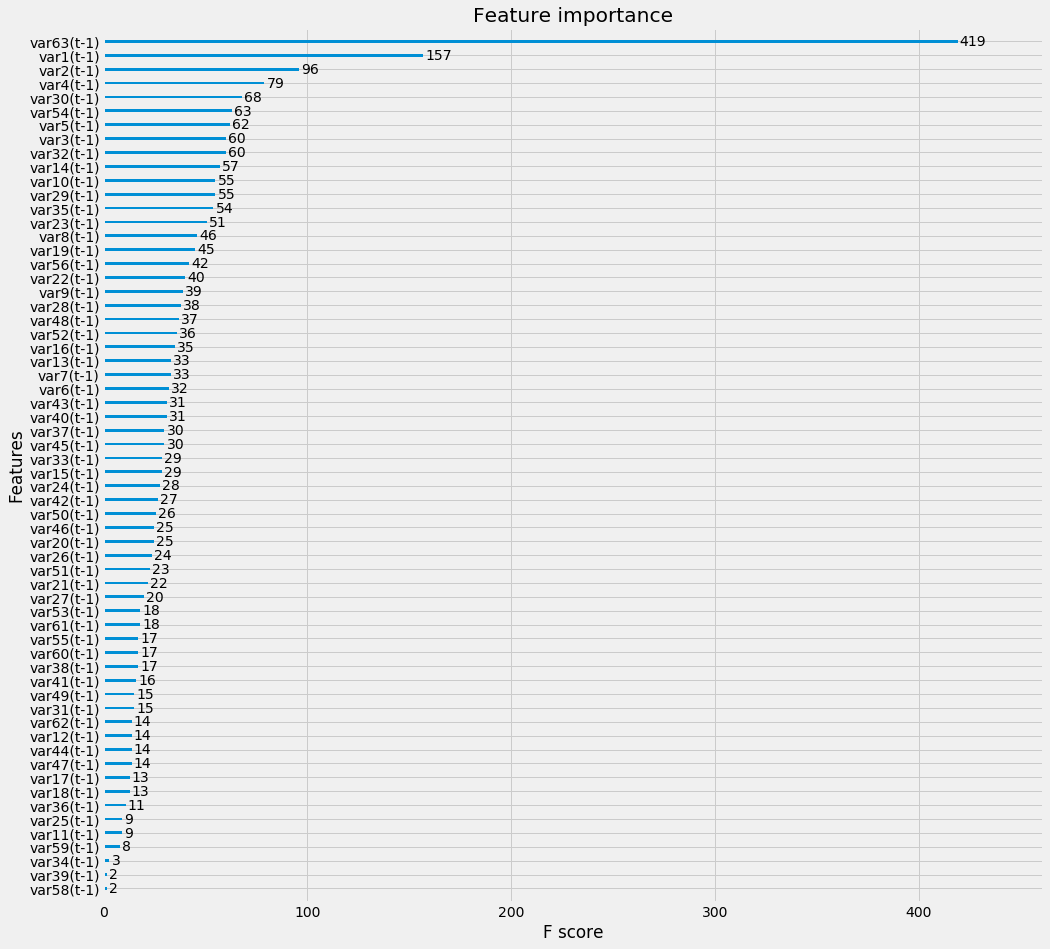

In [513]:
# feature importance plot
plt.rcParams["figure.figsize"] = (15, 15)
plot_importance(reg)

In [514]:
X_test_pred = reg.predict(X_test)
X_test_pred = [round(value) for value in X_test_pred]

In [515]:
mean_squared_error(y_true=Y_test,
                   y_pred=X_test_pred)

282084.83829787234

In [516]:
rmse = sqrt(mean_squared_error(y_true=Y_test,
                   y_pred=X_test_pred))

In [517]:
rmse

531.1165957658189

In [518]:
mean_absolute_error(y_true=Y_test,
                   y_pred=X_test_pred)

159.29422492401216

In [519]:
from sklearn.metrics import r2_score
r2_score(Y_test, X_test_pred)

0.9503687892215972

In [402]:
Y_test

outage_time_series.forecast_time_cdt
2019-03-03 02:00:00     58
2018-12-28 15:00:00     14
2017-10-30 06:00:00     11
2018-04-25 12:00:00    110
2018-02-24 13:00:00     29
2017-10-17 23:00:00     17
2017-09-29 22:00:00     18
2019-04-06 19:00:00    580
2018-07-15 08:00:00     88
2018-06-28 23:00:00     39
2018-10-26 07:00:00     52
2018-10-28 21:00:00     16
2018-04-13 15:00:00     22
2017-09-09 07:00:00    119
2018-06-15 02:00:00     73
2018-08-30 15:00:00     27
2018-09-03 01:00:00      9
2019-01-14 04:00:00      6
2018-04-08 22:00:00     56
2018-09-13 10:00:00     51
2018-09-15 19:00:00    599
2019-03-04 16:00:00     20
2019-01-10 06:00:00      2
2019-05-13 05:00:00     14
2017-10-17 20:00:00     20
2017-09-04 03:00:00     11
2017-08-22 03:00:00      9
2019-02-03 17:00:00      2
2018-02-19 06:00:00      7
2018-01-19 00:00:00      9
                      ... 
2018-01-01 09:00:00     25
2019-02-03 11:00:00     87
2019-01-26 02:00:00     11
2019-01-05 21:00:00      5
2018-07-09 00:00:0

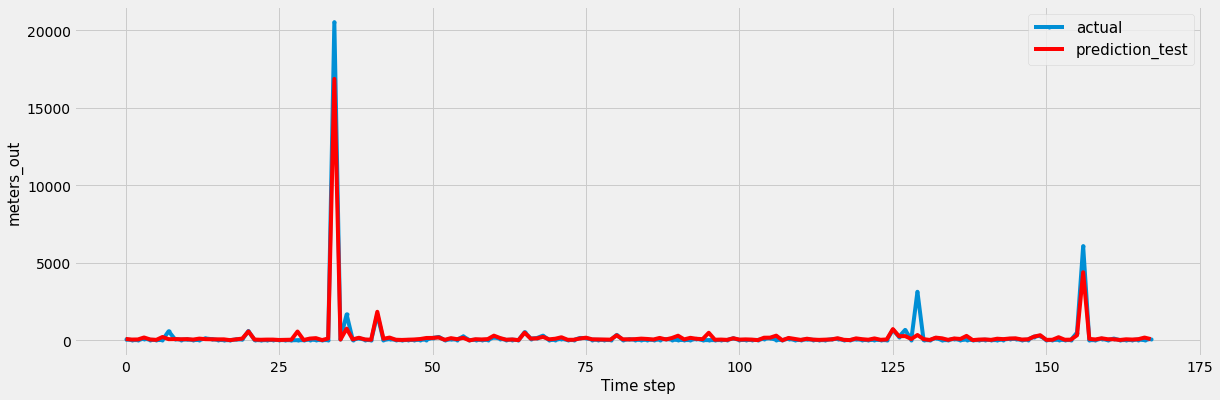

In [520]:
plt.rcParams["figure.figsize"] = (18, 6)
aa=[x for x in range(168)]
plt.plot(aa, Y_test[:168], marker='.', label="actual")
plt.plot(aa, X_test_pred[:168], 'r', label="prediction_test")
plt.ylabel('meters_out', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [521]:
Y_test =Y_test.reset_index()

In [522]:
Y_test['pred'] = X_test_pred

In [523]:
Y_test

,outage_time_series.forecast_time_cdt,var63(t),pred
0,2019-03-03 02:00:00,58,85.0
1,2018-12-28 15:00:00,14,48.0
2,2017-10-30 06:00:00,11,54.0
3,2018-04-25 12:00:00,110,181.0
4,2018-02-24 13:00:00,29,51.0
5,2017-10-17 23:00:00,17,28.0
6,2017-09-29 22:00:00,18,212.0
7,2019-04-06 19:00:00,580,72.0
8,2018-07-15 08:00:00,88,77.0
9,2018-06-28 23:00:00,39,66.0


In [524]:
TimeSeries = Y_test

In [542]:
TimeSeries = TimeSeries.sort_values('outage_time_series.forecast_time_cdt')
TimeSeries = TimeSeries.set_index('outage_time_series.forecast_time_cdt')

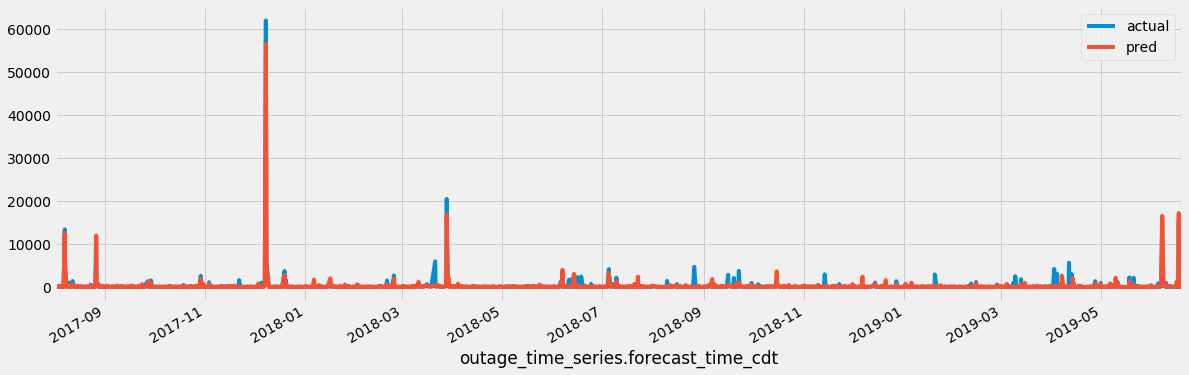

In [535]:
TimeSeries.plot.line()

In [ ]:
TimeSeries.rolling(60)                  # Create rolling windows
TimeSeries.rolling(60).mean().plot()    # Then apply functions to rolling windows

In [529]:
TimeSeries = TimeSeries.rename(columns={"var63(t)": "actual"})

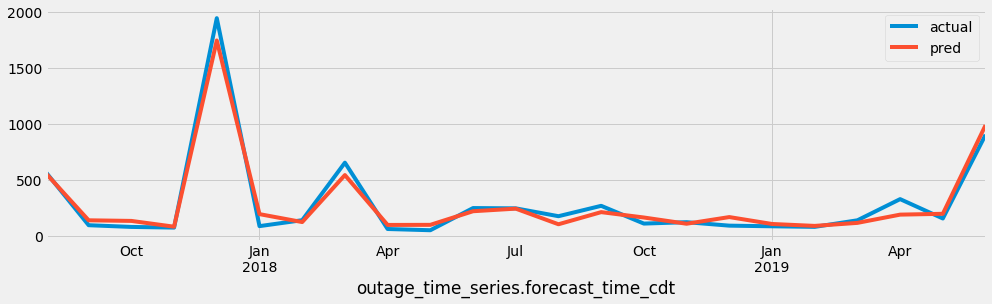

In [530]:
TimeSeries[["actual", "pred"]].resample("M").mean().plot(figsize=(15,4))

TimeSeries = TimeSeries.reset_index()
TimeSeries[TimeSeries['outage_time_series.forecast_time_cdt'] == '2017-11']

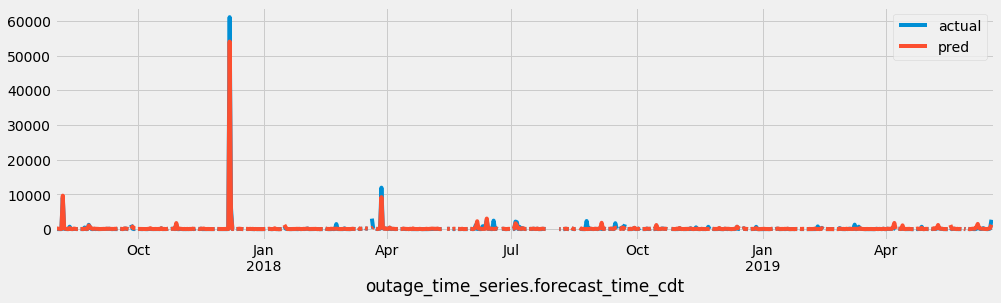

In [546]:
TimeSeries[["actual", "pred"]].resample("").median().plot(figsize=(15,4))

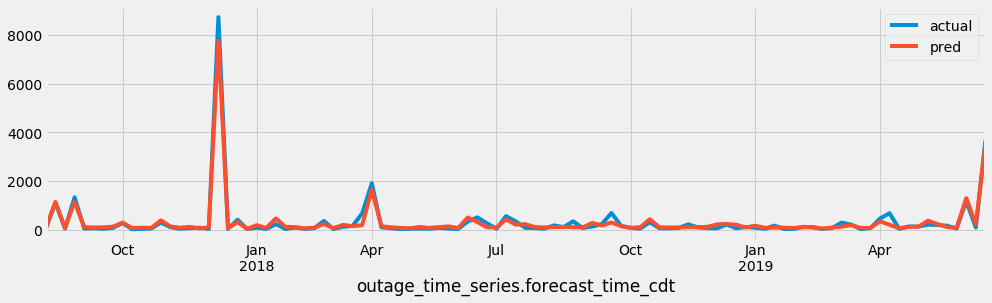

In [534]:
TimeSeries[["actual", "pred"]].resample("W").mean().plot(figsize=(15,4))

In [35]:
from datetime import timedelta

# Shap Plot for explanation of model

In [36]:
import shap

In [37]:
shap.initjs()

In [38]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X)

In [39]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

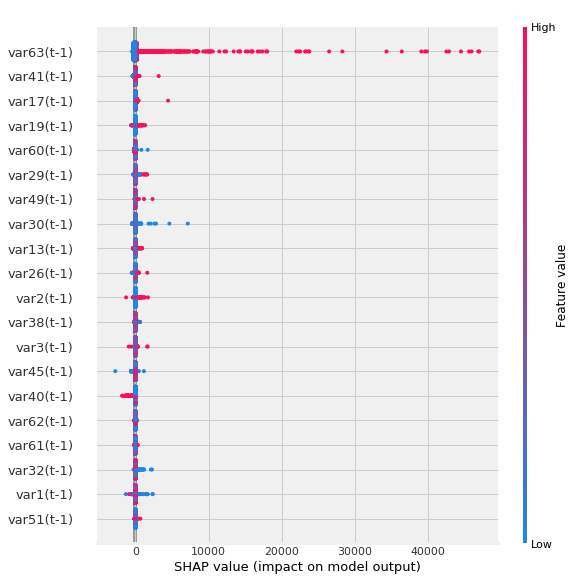

In [40]:
shap.summary_plot(shap_values, X)

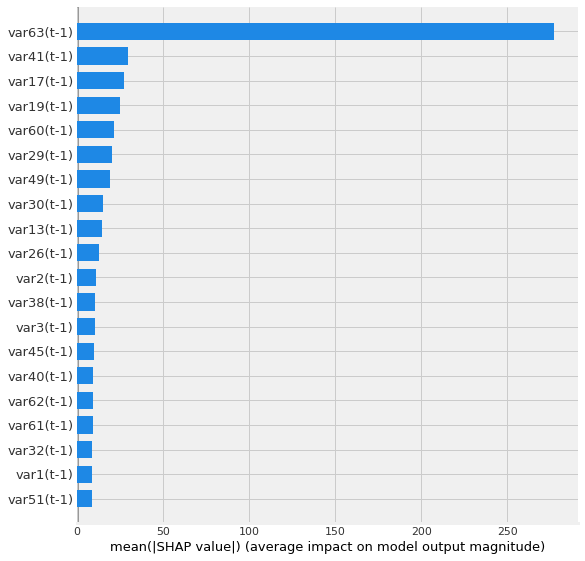

In [41]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
## PARAMETERS

popSize = 30 # Population size, set from 20 to 100
eliteSize = 0.1 # Percentage of elite instances to be retained 
nGeneration=3; # Number of generations

k_folds = 5 # Number of folds for cross-validation
paramList=['depth','nRound','eta','gamma','min_child_weight','lamda','alpha','colsample_bytree','subsample','fitness']

# XGBOOST MATRIX
dtrain = xgb.DMatrix(X_train, Y_train)

# Create an initial population
population=pd.DataFrame(np.zeros(shape=(popSize,len(paramList))),columns = paramList)
population.depth=[randint(5,15) for p in range(0,popSize)]
population.nRound=[randint(100,500) for p in range(0,popSize)] # n_boosting_rounds
population.eta=[random.uniform(0.6, 1) for p in range(0,popSize)] # learning_rate
population.gamma=[random.uniform(0.01, 0.03) for p in range(0,popSize)]
population.min_child_weight=[randint(10,100) for p in range(0,popSize)]
population.lamda =[random.uniform(0.1,1) for p in range(0,popSize)]
population.alpha =[random.uniform(0.1, 1) for p in range(0,popSize)]
population.colsample_bytree=[random.uniform(0.7, 1) for p in range(0,popSize)]
population.subsample=[random.uniform(0.7, 1) for p in range(0,popSize)]
population.fitness=[random.uniform(100, 100) for p in range(0,popSize)] # score

# Create a new population based on an existing one
def createNewPopulation(population, eliteSize=0.1, mutation_rate=0.2):
    population.sort_values(by='fitness',ascending=1,inplace=True)
    population.reset_index(drop=True,inplace=True)
    popSize=population.shape[0]
    nElite=int(round(eliteSize*popSize))
    
    new_population=population.copy(deep=True);
    # Form a new population from the top 50% instances
    for i in range(nElite,popSize):
        # Get two random parents
        p1=randint(nElite,int(popSize/2))
        p2=randint(nElite,int(popSize/2))
        
        for attr in list(new_population.columns.values):
            if(random.uniform(0,1)>0.5 ):
                new_population.loc[new_population.index[i], attr]=population.loc[new_population.index[p1], attr]
            else:
                new_population.loc[new_population.index[i], attr]=population.loc[new_population.index[p2], attr]

            # Generating some mutations
            # 
            # A list of if/else if is horrible, but Python doesn't like switchs
            # https://docs.python.org/3/tutorial/controlflow.html#if-statements 
            if(random.uniform(0,1)<mutation_rate ):
                attr=list(new_population.columns.values)[randint(0,8)]
                if(attr=='depth'):
                    new_population.loc[new_population.index[i], attr]= max(3,new_population.loc[new_population.index[i], attr]+randint(-2,2))
                elif(attr=='nRound'):
                    new_population.loc[new_population.index[i], attr]= max(10,new_population.loc[new_population.index[i], attr]+randint(-50,50))
                elif(attr=='eta'):
                    new_population.loc[new_population.index[i], attr]= max(0.1,new_population.loc[new_population.index[i], attr]+random.uniform(-0.05,0.05))
                elif(attr=='gamma'):
                    new_population.loc[new_population.index[i], attr]= max(0.1,new_population.loc[new_population.index[i], attr]+random.uniform(-0.005,0.005))
                elif(attr=='min_child_weight'):
                    new_population.loc[new_population.index[i], attr]= max(0,new_population.loc[new_population.index[i], attr]+randint(-2,2)  )                  
                elif(attr=='lamda'):
                    new_population.loc[new_population.index[i], attr]= max(0.1,new_population.loc[new_population.index[i], attr]+random.uniform(-0.05,0.05))                   
                elif(attr=='alpha'):
                    new_population.loc[new_population.index[i], attr]= max(0.1,new_population.loc[new_population.index[i], attr]+random.uniform(-0.05,0.05))                   
                elif(attr=='colsample_bytree'):
                    new_population.loc[new_population.index[i], attr]= min(1,max(0.6,new_population.loc[new_population.index[i], attr]+random.uniform(-0.05,0.05)))
                elif(attr=='subsample'):
                    new_population.loc[new_population.index[i], attr]= min(1,max(0.6,new_population.loc[new_population.index[i], attr]+random.uniform(-0.05,0.05)))                      
    return new_population

# Score each instance using k-fold CV
def testInstance(population,i,dtrain):
    params = {"objective": "reg:linear",
          "eta": population.eta[i],
          "max_depth": population.depth[i],
          "subsample": population.subsample[i],
          "colsample_bytree": population.colsample_bytree[i],
          "num_boost_round":int(population.nRound[i]),
          "lambda":population.lamda[i],
          "alpha":population.alpha[i],
          "gamma":population.gamma[i],
          "min_child_weight":population.min_child_weight[i],
          "silent": 1,
          "metrics": 'rmse'
          } 
    history = xgb.cv(
        params,
        dtrain,  
        early_stopping_rounds=30,
        num_boost_round  =int(population.nRound[i]),
        nfold=k_folds,
    )
    return history["test-rmse-mean"].iloc[-1]
#test-mae-mean

start_time = time.time()

# Main loop of the Evolutionary Algorithm: 
# Populations are created and avaluated.
for run in range(nGeneration):
    print("Generation %d\n" %run)
    population = createNewPopulation(population,eliteSize=0.1,mutation_rate=0.2)
    for i in range(popSize):
        print ("Testing instance %d "%i)
        population.iloc[i,-1]=testInstance(population,i,dtrain)
        print ("> Fitness %f \n " % population.fitness[i])
    population.sort_values(by='fitness',ascending=1,inplace=True)
    population.reset_index(drop=True,inplace=True)
    print("Generation %d Best fitness (%d-fold CV): %f" %(run, k_folds, population.fitness[0]))                

elapsed_time_secs = time.time() - start_time
print("Execution took: %s " % timedelta(seconds=round(elapsed_time_secs)))

# Output best parameters
best = population.iloc[0].to_dict()

params = {"objective": "reg:linear",
      "eta": best['eta'],
      "max_depth": int(best['depth']),
      "subsample": best['subsample'],
      "colsample_bytree": best['colsample_bytree'],
      "lambda":best['lamda'],
      "alpha":best['alpha'],
      "gamma":best['gamma'],
      "min_child_weight":best['min_child_weight'],
      "silent": 1,
      "metrics": 'rmse'
      } 


Generation 0

Testing instance 0 
> Fitness 1124.682617 
 
Testing instance 1 
> Fitness 1132.007300 
 
Testing instance 2 
> Fitness 1140.639722 
 
Testing instance 3 
> Fitness 1046.597961 
 
Testing instance 4 
> Fitness 1065.375513 
 
Testing instance 5 
> Fitness 1038.230505 
 
Testing instance 6 
> Fitness 923.282520 
 
Testing instance 7 
> Fitness 1141.298083 
 
Testing instance 8 
> Fitness 1055.189319 
 
Testing instance 9 
> Fitness 1016.262293 
 
Testing instance 10 
> Fitness 1064.645910 
 
Testing instance 11 
> Fitness 1083.227039 
 
Testing instance 12 
> Fitness 941.460486 
 
Testing instance 13 
> Fitness 1209.064770 
 
Testing instance 14 
> Fitness 1047.208728 
 
Testing instance 19 
> Fitness 966.226148 
 
Testing instance 20 
> Fitness 1072.755774 
 
Testing instance 21 
> Fitness 1058.118994 
 
Testing instance 22 
> Fitness 1077.361426 
 
Testing instance 23 
> Fitness 1076.669177 
 
Testing instance 24 
> Fitness 941.213965 
 
Testing instance 25 
> Fitness 108

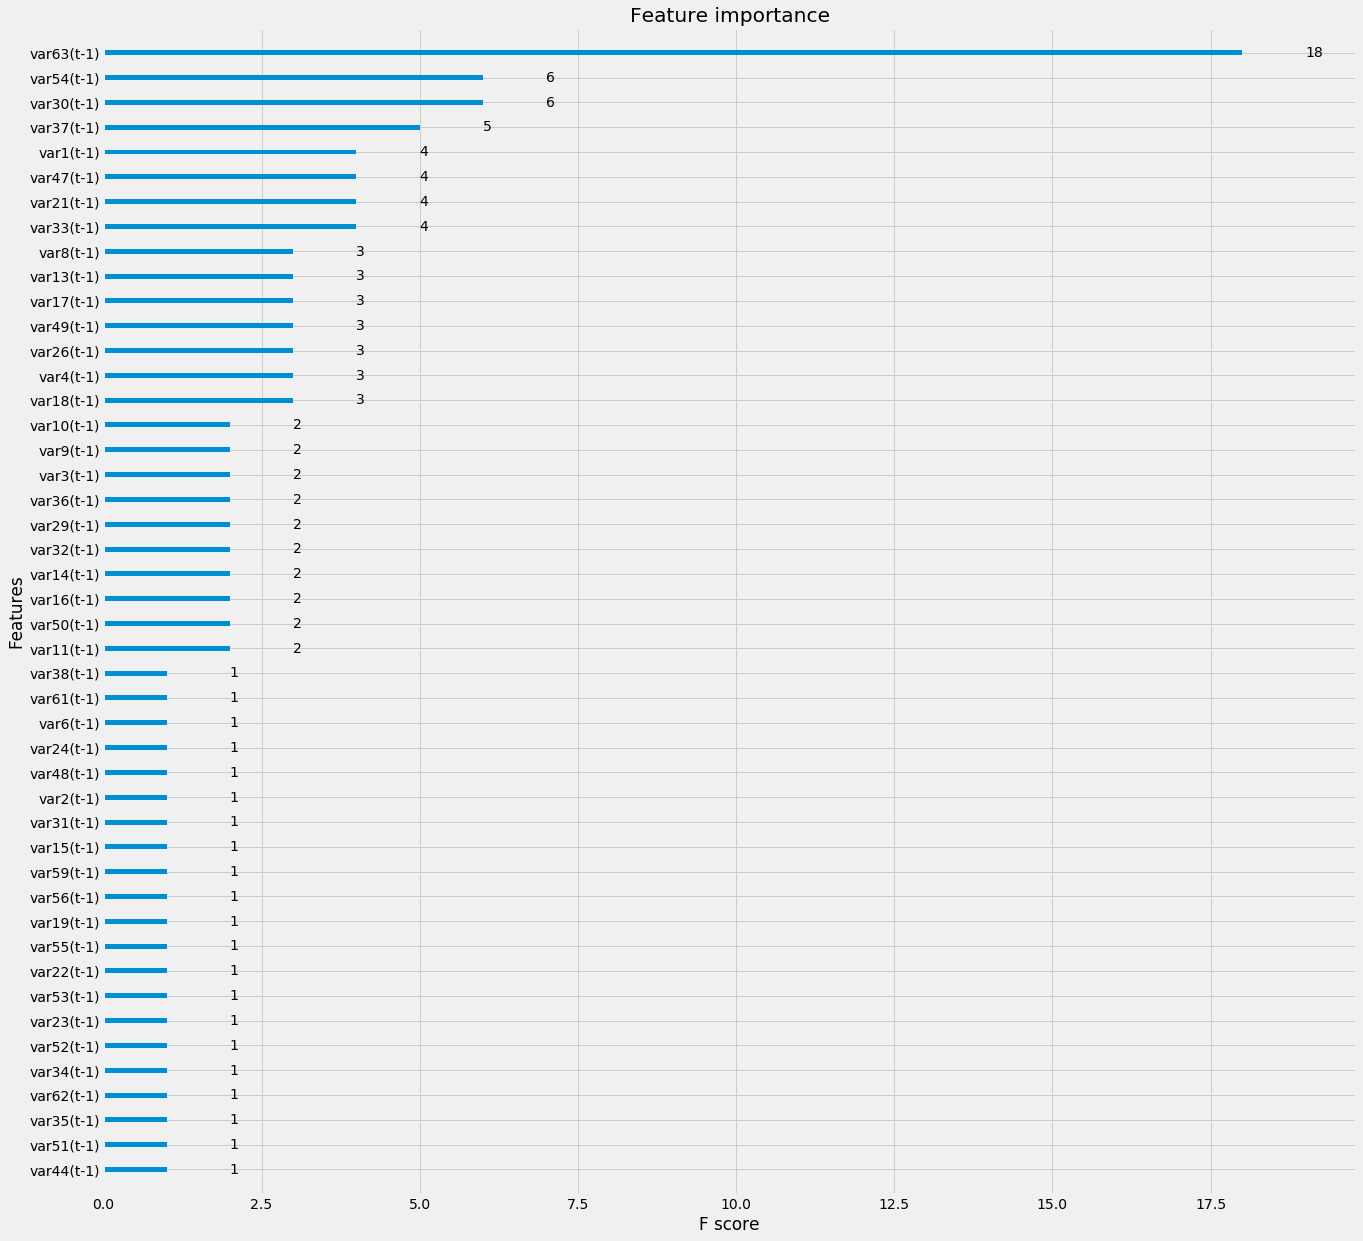

In [90]:
best_model = xgb.train(params,dtrain)
plt.rcParams["figure.figsize"] = (20,20)
# Plot feature importance and individual trees
xgb.plot_importance(best_model)
#Note that trees are far too large to view inline
#xgb.plot_tree(best_model,num_trees=3)

In [91]:
params

{'alpha': 0.8721384105189769,
 'colsample_bytree': 0.8525744957478514,
 'eta': 0.6174831595264174,
 'gamma': 0.012478532227498737,
 'lambda': 0.21100345531304587,
 'max_depth': 6,
 'metrics': 'rmse',
 'min_child_weight': 11.0,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.8538531418938103}

In [42]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8693675674380895, gamma=0.1, learning_rate=0.6426683994382433, max_delta_step=0,
       max_depth=5, metric='rmse', min_child_weight=80.0, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.7139224343493413, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample= 0.8911333363850376)
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8693675674380895, gamma=0.1,
       learning_rate=0.6426683994382433, max_delta_step=0, max_depth=5,
       metric='rmse', min_child_weight=80.0, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.7139224343493413, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=1,
       subsample=0.8911333363850376)

In [43]:
X_test_pred = reg.predict(X_test)
X_test_pred = [round(value) for value in X_test_pred]

In [44]:
mean_squared_error(y_true=Y_test,
                   y_pred=X_test_pred)

589588.5914893617

In [45]:
rmse = sqrt(mean_squared_error(y_true=Y_test,
                    y_pred=X_test_pred))

In [46]:
rmse

767.8467239556094

In [47]:
mean_absolute_error(y_true=Y_test,
                   y_pred=X_test_pred)

308.82370820668694

In [48]:
from sklearn.metrics import r2_score
r2_score(Y_test, X_test_pred)

0.8962652660337227

# Y(t) = Y(t-1) + X1(t-1) + X2(t-1) + ......

In [49]:
time_data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var55(t-1),var56(t-1),var57(t-1),var58(t-1),var59(t-1),var60(t-1),var61(t-1),var62(t-1),var63(t-1),var63(t)
outage_time_series.forecast_time_cdt,,,,,,,,,,,,,,,,,,,,,
2017-08-01 01:00:00,4424.74600,0.0,4616.63,-1401.064040,-3693.26441,0.0,-25160.0,172248.539,-31740.0,33032400.0,...,0.0,1092.715964,-0.866025,-0.5,-0.508531,-0.861044,0.000000,1.000000,12.0,15
2017-08-01 02:00:00,3977.15613,0.0,3998.14,-1076.822920,-4327.75922,0.0,-150.0,172140.714,-54770.0,33191300.0,...,0.0,1139.402145,-0.866025,-0.5,-0.508531,-0.861044,0.258819,0.965926,15.0,7
2017-08-01 03:00:00,4412.87024,0.0,3923.52,-852.059766,-4392.39239,0.0,0.0,172122.177,-56920.0,33297900.0,...,0.0,1204.813960,-0.866025,-0.5,-0.508531,-0.861044,0.500000,0.866025,7.0,6
2017-08-01 04:00:00,4388.69168,0.0,3416.41,-523.599330,-4816.81117,0.0,0.0,172004.229,-36310.0,33540100.0,...,0.0,1079.949393,-0.866025,-0.5,-0.508531,-0.861044,0.707107,0.707107,6.0,2
2017-08-01 05:00:00,4009.60140,0.0,2420.19,-495.900330,-5356.12060,0.0,-6320.0,171844.289,-22000.0,33722900.0,...,0.0,715.439696,-0.866025,-0.5,-0.508531,-0.861044,0.866025,0.500000,2.0,2


In [50]:
data.head()

,outage_time_series.vgrd_925_mb,outage_time_series.ltng_entire_atmosphere,outage_time_series.wind_10_m_above_ground,outage_time_series.ugrd_1000_mb,outage_time_series.vgrd_250_mb,outage_time_series.asnow_surface,outage_time_series.cin_90_0_mb_above_ground,outage_time_series.tmp_700_mb,outage_time_series.cin_surface,outage_time_series.pres_highest_tropospheric_freezing_level,...,outage_time_series.tmp_850_mb,outage_time_series.dswrf_surface,outage_time_series.vgrd_1000_mb,month_sin,month_cos,week_sin,week_cos,hour_sin,hour_cos,meters.out
outage_time_series.forecast_time_cdt,,,,,,,,,,,,,,,,,,,,,
2017-08-01 00:00:00,4424.74600,0.0,4616.63,-1401.064040,-3693.26441,0.0,-25160.0,172248.539,-31740.0,33032400.0,...,176623.474,0.0,1092.715964,-0.866025,-0.5,-0.508531,-0.861044,0.000000,1.000000,12
2017-08-01 01:00:00,3977.15613,0.0,3998.14,-1076.822920,-4327.75922,0.0,-150.0,172140.714,-54770.0,33191300.0,...,176321.956,0.0,1139.402145,-0.866025,-0.5,-0.508531,-0.861044,0.258819,0.965926,15
2017-08-01 02:00:00,4412.87024,0.0,3923.52,-852.059766,-4392.39239,0.0,0.0,172122.177,-56920.0,33297900.0,...,175907.811,0.0,1204.813960,-0.866025,-0.5,-0.508531,-0.861044,0.500000,0.866025,7
2017-08-01 03:00:00,4388.69168,0.0,3416.41,-523.599330,-4816.81117,0.0,0.0,172004.229,-36310.0,33540100.0,...,175599.082,0.0,1079.949393,-0.866025,-0.5,-0.508531,-0.861044,0.707107,0.707107,6
2017-08-01 04:00:00,4009.60140,0.0,2420.19,-495.900330,-5356.12060,0.0,-6320.0,171844.289,-22000.0,33722900.0,...,175441.961,0.0,715.439696,-0.866025,-0.5,-0.508531,-0.861044,0.866025,0.500000,2


In [131]:
X_test_pred = reg.predict(X_test)
X_test_pred = [round(value) for value in X_test_pred]

In [132]:
rmse = sqrt(mean_squared_error(y_true=Y_test,
                    y_pred=X_test_pred))

In [133]:
rmse

1277.3154720451994

In [134]:
mean_absolute_error(y_true=Y_test,
                   y_pred=X_test_pred)

604.3613445378152

In [135]:
from sklearn.metrics import r2_score
r2_score(Y_test, X_test_pred)

0.9431080197182197